In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import tensorflow as tf

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm


import os
import pickle
import pandas as pd
from skimage import transform
import matplotlib.pyplot as plt
import time

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

keras = tf.keras



## Configurable parameters

You can change these to another model.

To get the values for `last_conv_layer_name` and `classifier_layer_names`, use
 `model.summary()` to see the names of all layers in the model.


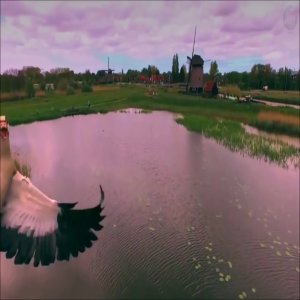

In [6]:
# model_builder = keras.applications.xception.Xception
img_size = (299, 299)
IMG_SIZE = 224 # All images will be resized to 224*224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

preprocess_input = keras.applications.xception.preprocess_input
# decode_predictions = keras.applications.xception.decode_predictions

# The local path to our target image
#img_path = keras.utils.get_file(
#    "cat.jpg", " https://i.imgur.com/rFBiyeR.jpg"
#)
img_path = '/tf/notebooks/collision_avoidance/data/2020-03-10/images/video-00008-frame-00069.png'
display(Image(img_path))

## The Grad-CAM algorithm

In [3]:

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    print(last_conv_layer)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

## Let's test-drive it


In [4]:
mobilenet_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                   include_top=True,
                                                   weights='imagenet')
mobilenet_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
#mobilenet_model = tf.keras.models.load_model("models/MobileNetV2-50.50-pervideo-ud-1588693063")
mobilenet_model = tf.keras.models.load_model("models/MobileNetV2-50.50-pervideo-ud-1594853029")

mobilenet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

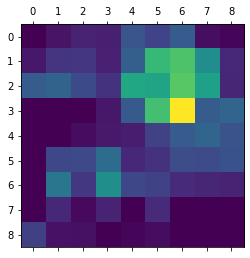

In [8]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
# model = model_builder(weights="imagenet")
IMG_SIZE = 224 # All images will be resized to 160x160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
#mobilenet_model = tf.keras.models.load_model("models/VGG-50.50-pervideo-ud-1588702595")
#mobilenet_model = tf.keras.models.load_model("models/MobileNetV2-50.50-pervideo-ud-1588693063")
mobilenet_model = tf.keras.models.load_model("models/MobileNetV2-50.50-pervideo-ud-1594853029")
#mobilenet_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                   include_top=True,
#                                                   weights='imagenet')
mobilenet_model.summary()


last_conv_layer = mobilenet_model.get_layer(index=-3)

print('XXX')
print(last_conv_layer.output)
print('XXX')


classifier_layer_names = [
    mobilenet_model.get_layer(index=-2).name,
    mobilenet_model.get_layer(index=-1).name,
]


# Print what the top predicted class is
preds = mobilenet_model.predict(img_array)
# print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, mobilenet_model, last_conv_layer, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()



## Create a superimposed visualization


In [ ]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "cat2.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))
